# Prescriptive part of the problem: divide & conquer deterministic approach

Optimization problem to solve: 
maximize total profit on the portfolio by finding personalized rebate/surcharge coefficients while maintaining a certain percentage of customers in the portfolio.

**Note: for the rest of this study, we will search personalized surcharge coefficients** ```delta``` **between -5% and 10% for each customer**.

Difficulties:
- large scale problem (one variable to optimize per client i: the rebate/surcharge coefficient delta_i)
- nonlinear problem, both in the objective (profit_i = retention_proba_i(delta_i) . [premium_i . (1+delta_i) - cost_i]) and the global constraint (avg(retention_proba_i for i in range(N)) > min_global_retention_rate)

Divide & conquer deterministic resolution:
- **(a)**: cluster clients, then optimize the problem by giving all the members of each cluster the same rebate/surcharge coefficient 
- **(b)**: start from the results of **(a)**, and solve independent optimization subproblems in each cluster by initializing them with the solution found with **(a)**; the constraint of each subproblem has to be adapted such that the aggregate solution remains a solution of the original problem.

### Packages importations

In [ ]:
import pandas as pd
import sys
import numpy as np
import nlopt
import os
import matplotlib.pyplot as plt
from collections import Counter
from copy import deepcopy, copy

from sklearn.cluster import MiniBatchKMeans

import scipy.sparse as sp
from scipy.optimize import minimize

### Dataset importation

In [ ]:
os.chdir("### path to the dataset ###")

In [ ]:
contract_df = pd.read_csv("ptf_mrh_2020_elast_plr.csv")

In [ ]:
contract_df = contract_df.set_index("id_police").dropna()

### Crafting features to cluster clients

To cluster clients into small groups where we will prescribe the same rebate/surcharge, we compute 3 features for each client:
- ```profitability```
- ```elasticity_10``` (the client's price elasticity for a 10% surcharge)
- ```proba_resil_10``` (the client's resiliation probability for a 10% surcharge)

In [ ]:
def getResiliationProba(row, delta):
    return 1/(1+np.exp(-row['coeff_non_prix']-100*delta*row['coeff_prix']))

In [ ]:
# we devise a surcharge of 10% for all customers to estimate how their price elasticity and churn probability would evolve (and cluster them afterwards)
delta = 0.1   

In [ ]:
proba_resil_delta_series = contract_df.apply(getResiliationProba, args=(delta,), axis=1)

In [ ]:
df_for_clustering = pd.DataFrame()
delta_for_col_names = delta*100

df_for_clustering['profitabilite'] = contract_df['prime_profit']/contract_df['pcc']
df_for_clustering['elasticite_%d' % delta_for_col_names] = (
    proba_resil_delta_series-contract_df['proba_resil_0%']
)/(contract_df['proba_resil_0%']*delta)
df_for_clustering['proba_resil_%d' % delta_for_col_names] = proba_resil_delta_series

df_for_clustering = (df_for_clustering-df_for_clustering.mean())/df_for_clustering.std()

In [ ]:
# the 3 features according to which we will cluster our clients
df_for_clustering

,profitabilite,elasticite_10,proba_resil_10
id_police,,,
0,1.983197,0.857149,-0.464225
1,0.710828,0.721616,-0.817799
2,1.757481,-1.052396,-1.055038
3,1.317235,-0.791398,-0.654801
4,1.344020,-0.888922,-0.307932
...,...,...,...
657102,0.065504,1.003791,2.508116
657103,-0.473630,0.222948,0.767509
657104,-0.976454,0.307993,0.138574


Visualization of the clients along the 3 clustering axes



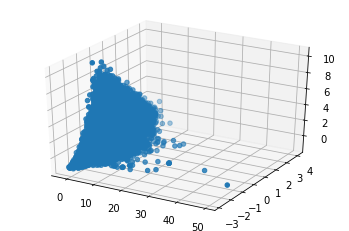

In [ ]:
viz = plt.figure().gca(projection='3d')
viz.scatter(df_for_clustering['profitabilite'], df_for_clustering['elasticite_%d' % delta_for_col_names], df_for_clustering['proba_resil_%d' % delta_for_col_names])
plt.show()

(2 axes seem quite correlated... Could be fixed)

## 1. Clustering via K-Means mini-batch

Given the size of the portfolio, using K-Means mini-batch for clustering is very efficient.

In [ ]:
# The number of clusters should be a hyperparameter of the optimization pipeline (and not necessarily using the elbow method); 
# however, for lack of computational power, we fix K to 150 (based on business knowledge) and do not tune this hyperparameter further.
clusteringMiniBatchKMeans = MiniBatchKMeans(n_clusters=150)  

In [ ]:
clusteringMiniBatchKMeans.fit(sp.csr_matrix(df_for_clustering))

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=150, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [ ]:
labelList = list(clusteringMiniBatchKMeans.labels_)

counter = Counter(labelList)
nb_of_elem_per_cluster = list(counter.values())

In [ ]:
print("Min nb of clients in a cluster : "+str(min(nb_of_elem_per_cluster)))
print("Max nb of clients in a cluster : "+str(max(nb_of_elem_per_cluster)))
print("Avg nb of clients in the clusters : "+str(int(np.mean(nb_of_elem_per_cluster))))
print("Total nb of clients in all the clusters (sanity check) : "+str(np.sum(nb_of_elem_per_cluster)))

125
9738
4379
656858


Let us then creat a Python dictionary to store the clustering results (client affiliations for each cluster):


In [ ]:
def createClusters(X, labelList):
    
    X_copy = deepcopy(X)
    X_copy['label'] = pd.Series(labelList)
    resDict = {}
    
    for label in set(labelList):
        resDict[str(label)] = X_copy[X_copy['label'] == label].drop('label', axis=1).reset_index()
    
    return resDict

In [ ]:
resDict = createClusters(contract_df, labelList)

This way, we can access the 6th cluster this way for instance:

In [ ]:
resDict['5']

,id_police,prime_profit,pcc,coeff_non_prix,coeff_prix,proba_resil_0%,proba_resil_5%
0,50565,437.90,153.326984,-2.657583,0.043251,0.065523,0.080075
1,69969,351.96,253.984331,-2.847394,0.005251,0.054816,0.056192
2,71180,834.12,459.834032,-3.686170,0.010751,0.024455,0.025771
3,82972,378.97,203.196501,-2.692615,0.040251,0.063411,0.076466
4,91295,482.94,358.311079,-4.011338,0.012251,0.017787,0.018889
...,...,...,...,...,...,...,...
2663,650920,147.84,91.498832,-4.395845,0.003751,0.012178,0.012406
2664,650955,132.96,103.221909,-3.563658,0.037251,0.027554,0.033009
2665,650959,118.80,192.179803,-3.405330,0.029251,0.032129,0.037002
2666,650975,157.52,123.560559,-1.338326,0.015251,0.207785,0.220617


## 2. Resolution of **(a)**: prescribing the same rebate/surcharge to all customers within a cluster

Creation of an "average individual" per cluster:

In [ ]:
cols = list(contract_df)
cluster_averages_df = pd.DataFrame(
    columns=cols
)

for k in range(len(resDict)):
    
    df = resDict[str(k)]
    n = len(df)     
    # the feature values of each "average individual" (one per cluster) take into account the size of the cluster
    cluster_averages_df = cluster_averages_df.append(
        dict(
            ((col, df[col].mean()*n if (col == 'prime_profit' or col == 'pcc') 
              else df[col].mean()) 
             for col in cols)
        ),
        ignore_index=True
    )              

   
cluster_averages_df 

,prime_profit,pcc,coeff_non_prix,coeff_prix,proba_resil_0%,proba_resil_5%
0,3.317799e+06,1.986045e+06,-3.007275,0.019025,0.062042,0.068871
1,1.716464e+06,1.091931e+06,-2.830456,0.020620,0.071181,0.079485
2,1.690296e+06,1.259597e+06,-2.748224,0.023906,0.073428,0.083021
3,9.447454e+05,5.040803e+05,-3.102312,0.016932,0.056435,0.062132
4,1.001654e+06,6.969500e+05,-2.757095,0.022350,0.075305,0.084661
...,...,...,...,...,...,...
145,2.406174e+06,1.418919e+06,-2.955996,0.018875,0.064324,0.071317
146,4.170932e+05,3.299789e+05,-2.714482,0.025417,0.073893,0.083882
147,2.199044e+06,1.238014e+06,-3.066606,0.017638,0.059229,0.065381
148,1.534561e+06,1.009920e+06,-2.840508,0.021557,0.069042,0.077332


Let us now start setting up the optimization problems with nlopt.


We first create the objective function that will be used to solve all our maximization problems (only the ```cluster_df``` argument will change from one problem to another):

In [ ]:
def buildObjectiveFunctionForSpecificCluster(cluster_df):
    
    df = cluster_df
    prime_profit = df['prime_profit']
    pcc = df['pcc']
    A = df['coeff_non_prix']
    B = df['coeff_prix']
    
    
    def objectiveFunction(delta, grad):
        # delta is the majorations vector, of size equal to cluster_df's row nb
        
        retention_proba = 1-(1/(1+np.exp(-A-100*pd.Series(delta)*B)))
        
        if grad.size > 0:
            
            grad[:] = (
                -(
                    1-retention_proba
                )*(
                    prime_profit+B/(1+np.exp(pd.Series(delta)*100*B+A))*(prime_profit*(1+pd.Series(delta))-pcc)
                )+prime_profit
            ).values            
        
        return ((prime_profit*(1+pd.Series(delta))-pcc)*retention_proba).sum()
        
    return objectiveFunction
    

We then create the function implementing the global inequality constraint for
the optimization problem that will prescribe the same rebate/surcharge to all members within a cluster (ie global constraint of pb **(a)**):

In [ ]:
def buildConstraintsForAverageClients(
    cluster_dict, min_retention_rate, delta_min, delta_max
):

    K = len(cluster_dict)
    N = len(contract_df)
    
    def globalConstraint(delta, grad):
        # delta is the majorations vector, *here* of size equal to the number K of clusters!
        
        total_mean_retention_proba = 0

        if grad.size > 0:
        
            for k in range(K):
                
                cluster_k = cluster_dict[str(k)]
                a = cluster_k['coeff_non_prix']
                b = cluster_k['coeff_prix']
                cluster_k_resiliation_probas = (1/(1+np.exp(-a-100*delta[k]*b)))
                
                grad[k] = (1/N)*(cluster_k_resiliation_probas*b*100/(1+np.exp(a+b*delta[k]*100))).sum()
                
                total_mean_retention_proba += (1-cluster_k_resiliation_probas).sum()
                
        return min_retention_rate-(1/N)*total_mean_retention_proba

    
    lower_bound = [delta_min for i in range(K)]
    upper_bound = [delta_max for i in range(K)]
    delta_bounds = (lower_bound, upper_bound)         
    

    return delta_bounds, globalConstraint


We then create the function implementing the global inequality constraint for all the optimization subproblems (cf pb **(b)**: one subproblem per cluster, initialized with the solution of the optimization problem that prescribed the same coefficient to all individuals within a cluster):

In [ ]:
def buildConstraintsForSpecificCluster(
    cluster_df, min_retention_rate, delta_min, delta_max
):
    
    df = cluster_df
    A = df['coeff_non_prix']
    B = df['coeff_prix']   
    N = len(df)
    
    
    def globalConstraint(delta, grad):
    # delta is the majorations vector, of size equal to total_df's length!

        retention_proba = 1-(1/(1+np.exp(-A-100*pd.Series(delta)*B)))

        if grad.size > 0:

            grad[:] = (
                (1/N)*(1-retention_proba)*B*100/(1+np.exp(A+B*pd.Series(delta)*100))
            ).values

        return min_retention_rate-(1/N)*retention_proba.sum()   
             
        
    lower_bound = [delta_min for i in range(N)]
    upper_bound = [delta_max for i in range(N)]
    delta_bounds = (lower_bound, upper_bound)
    
    return delta_bounds, globalConstraint


We then define the following function which we will use to optimize the optimization problem **(a)** on the K "average individuals":

(Note: we solve the problem for different initial coefficients, as the solution returned by the algorithm will depend on these initial values)

In [ ]:
def optimizeMarginForAverageClients(
    cluster_averages_df, cluster_dict, global_min_retention_rate, delta_min, delta_max, delta_init_list
):
    
    objectiveFunction = buildObjectiveFunctionForSpecificCluster(cluster_averages_df)
    #preconditioning = buildPreconditioningForSpecificCluster(cluster_averages_df)   #à tester
    delta_bounds, globalConstraint = buildConstraintsForAverageClients(
        cluster_dict, global_min_retention_rate, delta_min, delta_max
    )
    N = len(cluster_averages_df)

    opt = nlopt.opt(nlopt.LD_CCSAQ, N)
    opt.set_lower_bounds(delta_bounds[0])
    opt.set_upper_bounds(delta_bounds[1])
    opt.set_max_objective(objectiveFunction)
    #opt.set_precond_min_objective(objectiveFunction, preconditioning)   #à tester
    opt.add_inequality_constraint(globalConstraint)
    opt.set_xtol_abs(1e-20)
    
    print("Starting cluster average clients optimization.")
    
    delta_opt_for_various_delta0s = []
    margin_for_various_delta0s = []
    ineq_cons_for_various_delta0s = []
    
    # we run the solver of (a) for different initial coefficients and will keep the best result
    for delta_init_scalar in delta_init_list:
        
        rounded_delta_init_scalar = round(delta_init_scalar,4)
        delta0 = rounded_delta_init_scalar*np.ones(N)
        delta_opt = opt.optimize(delta0)
        margin = opt.last_optimum_value()
        ineq_cons = globalConstraint(delta_opt,np.zeros(N))
        print("Cluster average clients optimization done for "+str(rounded_delta_init_scalar)+" initial point!")
        print("Optimal margin for this init point: "+str(margin))
        print("Inequality constraint gap for this init point: "+str(ineq_cons)+" (has to be negative or quasi-null)")
        print("\n")
        
        delta_opt_for_various_delta0s.append(delta_opt)
        margin_for_various_delta0s.append(margin)
        ineq_cons_for_various_delta0s.append(ineq_cons)
        
    deltas = copy(delta_opt_for_various_delta0s)
    margins = copy(margin_for_various_delta0s)
    ineqs = copy(ineq_cons_for_various_delta0s)
    
    while True:
        
        if len(margins) == 0:
            
            i = ineq_cons_for_various_delta0s.index(min(ineq_cons_for_various_delta0s))
            print("No result found satisfies inequality constraint")
            print("Closest to acceptable margin: "+str(margin_for_various_delta0s[i]))
            print("\n")
            return margin_for_various_delta0s[i], delta_opt_for_various_delta0s[i]
        
        
        max_margin = max(margins)
        i = margins.index(max_margin)
        
        # our criterion to consider the constraints tight
        if ineqs[i] < 10**(-3):  
            
            print("Optimal margin: "+str(margins[i]))
            print("\n")
            return max_margin, deltas[i]
        
        else:
            
            deltas.pop(i)
            margins.pop(i)
            ineqs.pop(i)       



Test of the previously defined function solving problem **(a)** for a set of parameter values:

In [ ]:
delta_min, delta_max = -0.05, 0.1
step = 0.05
delta_init_list = np.arange(delta_min, delta_max+step, step)
global_min_retention_rate = 0.919
cluster_dict = resDict

In [ ]:
margin, delta = optimizeMarginForAverageClients(
    cluster_averages_df, cluster_dict, global_min_retention_rate, delta_min, delta_max, delta_init_list
)

Starting cluster average clients optimization.
Cluster average clients optimization done for -0.05 initial point!
Optimal margin for this init point: 94515239.42375694
Inequality constraint gap for this init point: 0.00031462672944160275 (has to be negative or quasi-null)


Cluster average clients optimization done for 0.0 initial point!
Optimal margin for this init point: 94253193.47011122
Inequality constraint gap for this init point: 4.5823592890181786e-06 (has to be negative or quasi-null)


Cluster average clients optimization done for 0.05 initial point!
Optimal margin for this init point: 94811555.42447811
Inequality constraint gap for this init point: 0.0006739724739438513 (has to be negative or quasi-null)


Cluster average clients optimization done for 0.1 initial point!
Optimal margin for this init point: 94280926.54697937
Inequality constraint gap for this init point: 4.486126373892674e-05 (has to be negative or quasi-null)


Optimal margin: 94811555.42447811




We obtain here "a priori" a total profit of 94811555 euros. However, as seen in the report, this is not exactly the total margin obtained by prescribing the solution ```delta``` to our customers, solution which we found by optimizing problem **(a)**:

In [ ]:
delta

array([ 0.1       ,  0.1       ,  0.05515781,  0.1       ,  0.07590085,
        0.04632132,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
        0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.05136901,
        0.08083542,  0.06175693,  0.1       ,  0.08270557,  0.1       ,
        0.02863668,  0.08157194,  0.06108086,  0.1       ,  0.05352459,
        0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
        0.1       ,  0.1       ,  0.1       ,  0.05494666,  0.02286292,
        0.1       ,  0.1       ,  0.1       ,  0.06544823,  0.1       ,
        0.07044116,  0.1       ,  0.09966711,  0.1       ,  0.1       ,
        0.1       ,  0.1       ,  0.03512785,  0.03843148,  0.1       ,
        0.07771691,  0.1       ,  0.1       ,  0.05494782,  0.1       ,
        0.1       ,  0.1       , -0.01711243,  0.0909422 ,  0.1       ,
        0.1       ,  0.09683303,  0.1       ,  0.1       ,  0.1       ,
        0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.05

Indeed, since problem **(a)** relies on the "average individuals" that have weighted feature values to compute objective function, the optimal objective returned by the algorithm is not exactly the optimal total profit here. We go back to the optimal total profit by simply applying a ```delta```[k] surcharge to all individuals of cluster k.

We therefore define a function to calculate the real profit based on the rebate/surcharge coefficient ```delta```[k] prescribed to each cluster in the previously printed ```delta``` vector:

In [ ]:
def computeMarginEntireDataset(cluster_dict, delta_opt_for_each_cluster):
    
    res = 0
    K = len(cluster_dict)
    
    for k in range(K):
        
        df = cluster_dict[str(k)]
        n = len(df)
        objectiveFunction = buildObjectiveFunctionForSpecificCluster(df)
        delta_opt = delta_opt_for_each_cluster[k]*np.ones(n)
        
        res += objectiveFunction(delta_opt, np.empty((len(df),0)))
    
    return res


In [ ]:
res = computeMarginEntireDataset(resDict, delta)

In [ ]:
res

93150079.7085912

The optimal total profit is thus 93150079 euros and not 94811555.

Before turning to problem **(b)** which improves over problem **(a)**, let us finally analyze the histogram of the ```delta``` vector whose components indicate the rebate/surcharge to apply to each of the K clusters:

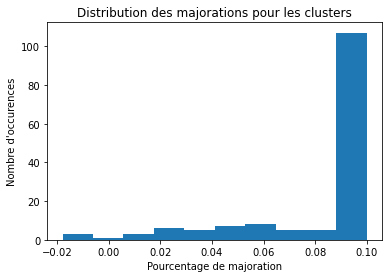

In [ ]:
plt.hist(list(delta), bins=10)
plt.title("Distribution of surcharge coefficients for the clusters")
plt.xlabel("Surcharge %")
plt.ylabel("Nb of occurences")
plt.savefig("### exportation path ###")
plt.show()

We can see that this histogram (although it does not multiply each ```delta```[k] component by n[k], the cardinal of cluster k) is not really polarized... There is still room for optimization! Hence the problem **(b)** right after **(a)** which we just tested.

## 3. Resolution of **(b)**: extending the results of **(a)** by solving per-cluster optimization subproblems

Let us exploit the previous results by extracting the new averages of the retention probabilities in each cluster, obtained by prescribing the ```delta```[k] surcharge (found in the solution to **(a)**) to each cluster k.

This will be used to modify the constraint of each subproblem and guarantee that the aggregated solution of all the subproblems remains a solution of the initial optimization problem.

First, we define a function that allows, for each cluster k, to compute its new average retention probability for a ```delta```[k] surcharge:

In [ ]:
def getNewMeanRetentionRates(cluster_dict, delta_opt_for_each_cluster):
    
    K = len(cluster_dict)
    mean_retention_rate_for_delta_opt = np.zeros(K)
    
    for k in range(K):
        
        df = cluster_dict[str(k)]
        mean_retention_rate_for_delta_opt[k] = (
            1-df.apply(getResiliationProba, args=(delta_opt_for_each_cluster[k],), axis=1)
        ).mean()
        
    return mean_retention_rate_for_delta_opt
    

In [ ]:
mean_retention_rate_for_delta_opt = getNewMeanRetentionRates(resDict, delta)

We then define the function that will perform the successive optimization of the K subproblems (each subproblem being solved on one of the K clusters), starting from the initial point (```delta```[k],...,```delta```[k]) for each cluster k, and respecting the global constraint of inequality for a min retention threshold worth the kth average calculated just above.

Note: as all subproblems are independent, it could have been possible to parallelize their resolution (ideally).

In [ ]:
def optimizeMarginForEntireDataset(
    cluster_dict, mean_retention_rate_for_delta_opt, delta_min, delta_max, delta_opt_for_each_cluster
):
    
    total_margin = 0
    delta_list = []
    K = len(cluster_dict)
    
    # we use the mean_retention_rate_delta_opt computed previously to formulate the constraint of each subproblem
    print('Starting cluster margin optimization.')
    for k in range(K):
        
        print("Starting cluster "+str(k)+" optimization.")
        cluster_df = cluster_dict[str(k)]
        objectiveFunction = buildObjectiveFunctionForSpecificCluster(cluster_df)
        delta_bounds, globalConstraint = buildConstraintsForSpecificCluster(
            cluster_df, mean_retention_rate_for_delta_opt[k], delta_min, delta_max
        )
        N = len(cluster_df)
        
        opt = nlopt.opt(nlopt.LD_CCSAQ, N)
        opt.set_lower_bounds(delta_bounds[0])
        opt.set_upper_bounds(delta_bounds[1])
        opt.set_max_objective(objectiveFunction)
        opt.add_inequality_constraint(globalConstraint)
        opt.set_xtol_rel(1e-7)
        
        delta0 = delta_opt_for_each_cluster[k]*np.ones(N)
        delta_opt = opt.optimize(delta0)
        maxf = opt.last_optimum_value()
        print("Cluster "+str(k)+" optimization done!")
        print("Optimal margin: "+str(maxf))
        print("Inequality constraint gap: "+str(globalConstraint(delta_opt,np.zeros(N)))+" (has to be negative or quasi-null)")
        
        total_margin += maxf
        delta_list.append(delta_opt)
        
    print('Optimization of total margin done!')
    print("\n")
    print("\n")
    
    return total_margin, np.concatenate(delta_list, axis=0)


Let us try to run the solver of **(b)** defined just above on the example we used to test the solver of **(a)** (with a ```global_min_retention_rate``` of 0.919):

In [ ]:
total_margin, total_delta = optimizeMarginForEntireDataset(
    resDict, mean_retention_rate_for_delta_opt, delta_min, delta_max, delta
)

Starting cluster margin optimization.
Starting cluster 0 optimization.
Cluster 0 optimization done!
Optimal margin: 1543493.4970666803
Inequality constraint gap: 1.4432899320127035e-15 (has to be negative or quasi-null)
Starting cluster 1 optimization.
Cluster 1 optimization done!
Optimal margin: 729457.9136564162
Inequality constraint gap: -1.1102230246251565e-15 (has to be negative or quasi-null)
Starting cluster 2 optimization.
Cluster 2 optimization done!
Optimal margin: 530911.706202318
Inequality constraint gap: -4.522067527767959e-06 (has to be negative or quasi-null)
Starting cluster 3 optimization.
Cluster 3 optimization done!
Optimal margin: 500804.1788422904
Inequality constraint gap: 4.440892098500626e-16 (has to be negative or quasi-null)
Starting cluster 4 optimization.
Cluster 4 optimization done!
Optimal margin: 365240.1050948454
Inequality constraint gap: 9.81783366316158e-06 (has to be negative or quasi-null)
Starting cluster 5 optimization.
Cluster 5 optimization don

Cluster 47 optimization done!
Optimal margin: 550421.6917854433
Inequality constraint gap: 5.685515462983126e-06 (has to be negative or quasi-null)
Starting cluster 48 optimization.
Cluster 48 optimization done!
Optimal margin: 397540.83286776807
Inequality constraint gap: -3.141329452116537e-07 (has to be negative or quasi-null)
Starting cluster 49 optimization.
Cluster 49 optimization done!
Optimal margin: 507091.58501155267
Inequality constraint gap: -2.3314683517128287e-15 (has to be negative or quasi-null)
Starting cluster 50 optimization.
Cluster 50 optimization done!
Optimal margin: 495445.124455184
Inequality constraint gap: -4.2801434840811226e-08 (has to be negative or quasi-null)
Starting cluster 51 optimization.
Cluster 51 optimization done!
Optimal margin: 920034.5124079799
Inequality constraint gap: 4.9960036108132044e-15 (has to be negative or quasi-null)
Starting cluster 52 optimization.
Cluster 52 optimization done!
Optimal margin: 714823.868171614
Inequality constrain

Cluster 92 optimization done!
Optimal margin: 533756.9110002085
Inequality constraint gap: 1.6611184112669264e-06 (has to be negative or quasi-null)
Starting cluster 93 optimization.
Cluster 93 optimization done!
Optimal margin: 557194.6990462214
Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 94 optimization.
Cluster 94 optimization done!
Optimal margin: 1240488.0816159458
Inequality constraint gap: 8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 95 optimization.
Cluster 95 optimization done!
Optimal margin: 453557.707355042
Inequality constraint gap: -3.3306690738754696e-16 (has to be negative or quasi-null)
Starting cluster 96 optimization.
Cluster 96 optimization done!
Optimal margin: 1074061.2941091051
Inequality constraint gap: -1.7763568394002505e-15 (has to be negative or quasi-null)
Starting cluster 97 optimization.
Cluster 97 optimization done!
Optimal margin: 588829.829138193
Inequality constraint

Cluster 137 optimization done!
Optimal margin: 733106.0690576329
Inequality constraint gap: -5.783461641040155e-06 (has to be negative or quasi-null)
Starting cluster 138 optimization.
Cluster 138 optimization done!
Optimal margin: 476888.0111085407
Inequality constraint gap: 1.1338585870879214e-05 (has to be negative or quasi-null)
Starting cluster 139 optimization.
Cluster 139 optimization done!
Optimal margin: 733545.490402
Inequality constraint gap: -2.220446049250313e-16 (has to be negative or quasi-null)
Starting cluster 140 optimization.
Cluster 140 optimization done!
Optimal margin: 159556.21488169115
Inequality constraint gap: -5.551115123125783e-16 (has to be negative or quasi-null)
Starting cluster 141 optimization.
Cluster 141 optimization done!
Optimal margin: 287281.7225547107
Inequality constraint gap: 1.192379528447418e-13 (has to be negative or quasi-null)
Starting cluster 142 optimization.
Cluster 142 optimization done!
Optimal margin: 798344.994778352
Inequality cons

Let us now display the histogram of the values of the aggregated surcharge vector ```delta```, obtained by concatenating the optimal surcharge vectors ```delta```_k of each of the K clusters:

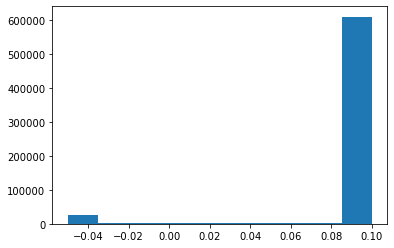

In [ ]:
plt.hist(list(total_delta), bins=10)
plt.show()

We can see that the vector of truly personalized surcharge coefficients (for the entire portfolio) is much more polarized here than in the solution of **(a)**.

In [ ]:
total_margin

94891080.81120718

We were indeed able to squeeze out a few millions more in terms of total profit compared to the result obtained by solving **(a)**.
Thus, extending the results of **(a)** by solving per-cluster optimization subproblems was worth it.

## 4. Drawing the "efficient frontier" using **(a)** and **(b)**


To draw the efficient frontier, we want to solve problem **(a)** + all the per-cluster subproblems **for each** ```global_min_retention_rate``` threshold (which intervenes in the expression of the global constraint of the inital problem) **between 88% and 97%** **(b)**.

Let us first set our study domain for ```global_min_retention_rate``` thresholds between 88% and 97%:

In [ ]:
minimal_min_retention_rate = 0.88
maximal_min_retention_rate = 0.97
step = 0.005
global_min_retention_rates = np.arange(minimal_min_retention_rate,maximal_min_retention_rate+step,step)
total_margins = np.zeros(len(global_min_retention_rates))
diffs = np.zeros(len(global_min_retention_rates))
cluster_dict, delta_min, delta_max = resDict, -0.05, 0.10

Then, for each ```global_min_retention_rate``` threshold between 88% and 97%, we run:
- the resolution of problem **(a)** (which leverages "average individuals" and prescribes the same surcharge coefficient to all the members of a cluster k)
- the resolution of the K independent subproblems (each adapted and initialized using the solutions of **(a)**), i.e. **(b)**

The function takes less than an hour to run.

In [ ]:
for i in range(len(total_margins)):
    
    global_min_retention_rate = round(global_min_retention_rates[i],4)
    
    print("*************")
    print("Starting optimization of margin for a "+str(global_min_retention_rate*100)+"% average retention rate")
    print("*************")
    print("\n")
    
    margin, delta = optimizeMarginForAverageClients(
        cluster_averages_df, cluster_dict, global_min_retention_rate, delta_min, delta_max, delta_init_list
    )
    total_margin_same_delta = computeMarginEntireDataset(resDict, delta)
    
    mean_retention_rate_for_delta_opt = getNewMeanRetentionRates(resDict, delta)
    total_margin, total_delta = optimizeMarginForEntireDataset(
        cluster_dict, mean_retention_rate_for_delta_opt, delta_min, delta_max, delta
    )

    total_margins[i] = total_margin
    diffs[i] = total_margin-total_margin_same_delta

*************
Starting optimization of margin for a 88.0% average retention rate
*************


Starting cluster average clients optimization.
Cluster average clients optimization done for -0.05 initial point!
Optimal margin for this init point: 97309836.97090256
Inequality constraint gap for this init point: -0.03495592507125622 (has to be negative or quasi-null)


Cluster average clients optimization done for 0.0 initial point!
Optimal margin for this init point: 97309836.97090256
Inequality constraint gap for this init point: -0.03495592507125622 (has to be negative or quasi-null)


Cluster average clients optimization done for 0.05 initial point!
Optimal margin for this init point: 97309836.97090256
Inequality constraint gap for this init point: -0.03495592507125622 (has to be negative or quasi-null)


Cluster average clients optimization done for 0.1 initial point!
Optimal margin for this init point: 97309836.97090256
Inequality constraint gap for this init point: -0.034955925071

Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 41 optimization.
Cluster 41 optimization done!
Optimal margin: 448055.4976328752
Inequality constraint gap: 1.1102230246251565e-16 (has to be negative or quasi-null)
Starting cluster 42 optimization.
Cluster 42 optimization done!
Optimal margin: 756887.5653943906
Inequality constraint gap: 1.4432899320127035e-15 (has to be negative or quasi-null)
Starting cluster 43 optimization.
Cluster 43 optimization done!
Optimal margin: 1216607.610397557
Inequality constraint gap: -2.7755575615628914e-15 (has to be negative or quasi-null)
Starting cluster 44 optimization.
Cluster 44 optimization done!
Optimal margin: 237579.0443616326
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 45 optimization.
Cluster 45 optimization done!
Optimal margin: 455279.0991402154
Inequality constraint gap: 1.1102230246251565e-15 (has to be negative or quasi-null)

Inequality constraint gap: 8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 95 optimization.
Cluster 95 optimization done!
Optimal margin: 470882.9197806101
Inequality constraint gap: 2.9976021664879227e-15 (has to be negative or quasi-null)
Starting cluster 96 optimization.
Cluster 96 optimization done!
Optimal margin: 1074061.2941091051
Inequality constraint gap: -1.7763568394002505e-15 (has to be negative or quasi-null)
Starting cluster 97 optimization.
Cluster 97 optimization done!
Optimal margin: 588829.829138193
Inequality constraint gap: 2.1094237467877974e-15 (has to be negative or quasi-null)
Starting cluster 98 optimization.
Cluster 98 optimization done!
Optimal margin: 520022.49563774443
Inequality constraint gap: -1.4432899320127035e-15 (has to be negative or quasi-null)
Starting cluster 99 optimization.
Cluster 99 optimization done!
Optimal margin: 713151.2522411055
Inequality constraint gap: -2.220446049250313e-15 (has to be negative or quasi-null

Inequality constraint gap: -2.220446049250313e-15 (has to be negative or quasi-null)
Starting cluster 146 optimization.
Cluster 146 optimization done!
Optimal margin: 116337.44493463033
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 147 optimization.
Cluster 147 optimization done!
Optimal margin: 1100665.8158192532
Inequality constraint gap: 6.661338147750939e-16 (has to be negative or quasi-null)
Starting cluster 148 optimization.
Cluster 148 optimization done!
Optimal margin: 622826.6504006698
Inequality constraint gap: 3.3306690738754696e-16 (has to be negative or quasi-null)
Starting cluster 149 optimization.
Cluster 149 optimization done!
Optimal margin: 631471.1694716092
Inequality constraint gap: -1.1102230246251565e-15 (has to be negative or quasi-null)
Optimization of total margin done!




*************
Starting optimization of margin for a 88.5% average retention rate
*************


Starting cluster average clients opt

Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 41 optimization.
Cluster 41 optimization done!
Optimal margin: 448055.4976328752
Inequality constraint gap: 1.1102230246251565e-16 (has to be negative or quasi-null)
Starting cluster 42 optimization.
Cluster 42 optimization done!
Optimal margin: 756887.5653943906
Inequality constraint gap: 1.4432899320127035e-15 (has to be negative or quasi-null)
Starting cluster 43 optimization.
Cluster 43 optimization done!
Optimal margin: 1216607.610397557
Inequality constraint gap: -2.7755575615628914e-15 (has to be negative or quasi-null)
Starting cluster 44 optimization.
Cluster 44 optimization done!
Optimal margin: 237579.0443616326
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 45 optimization.
Cluster 45 optimization done!
Optimal margin: 455279.0991402154
Inequality constraint gap: 1.1102230246251565e-15 (has to be negative or quasi-null)

Inequality constraint gap: -1.887379141862766e-15 (has to be negative or quasi-null)
Starting cluster 93 optimization.
Cluster 93 optimization done!
Optimal margin: 557194.6990462214
Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 94 optimization.
Cluster 94 optimization done!
Optimal margin: 1240488.0816159458
Inequality constraint gap: 8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 95 optimization.
Cluster 95 optimization done!
Optimal margin: 470882.9197806101
Inequality constraint gap: 2.9976021664879227e-15 (has to be negative or quasi-null)
Starting cluster 96 optimization.
Cluster 96 optimization done!
Optimal margin: 1074061.2941091051
Inequality constraint gap: -1.7763568394002505e-15 (has to be negative or quasi-null)
Starting cluster 97 optimization.
Cluster 97 optimization done!
Optimal margin: 588829.829138193
Inequality constraint gap: 2.1094237467877974e-15 (has to be negative or quasi-null)


Inequality constraint gap: -2.220446049250313e-15 (has to be negative or quasi-null)
Starting cluster 146 optimization.
Cluster 146 optimization done!
Optimal margin: 116337.44493463033
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 147 optimization.
Cluster 147 optimization done!
Optimal margin: 1100665.8158192532
Inequality constraint gap: 6.661338147750939e-16 (has to be negative or quasi-null)
Starting cluster 148 optimization.
Cluster 148 optimization done!
Optimal margin: 622826.6504006698
Inequality constraint gap: 3.3306690738754696e-16 (has to be negative or quasi-null)
Starting cluster 149 optimization.
Cluster 149 optimization done!
Optimal margin: 631471.1694716092
Inequality constraint gap: -1.1102230246251565e-15 (has to be negative or quasi-null)
Optimization of total margin done!




*************
Starting optimization of margin for a 89.0% average retention rate
*************


Starting cluster average clients opt

Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 41 optimization.
Cluster 41 optimization done!
Optimal margin: 448055.4976328752
Inequality constraint gap: 1.1102230246251565e-16 (has to be negative or quasi-null)
Starting cluster 42 optimization.
Cluster 42 optimization done!
Optimal margin: 756887.5653943906
Inequality constraint gap: 1.4432899320127035e-15 (has to be negative or quasi-null)
Starting cluster 43 optimization.
Cluster 43 optimization done!
Optimal margin: 1216607.610397557
Inequality constraint gap: -2.7755575615628914e-15 (has to be negative or quasi-null)
Starting cluster 44 optimization.
Cluster 44 optimization done!
Optimal margin: 237579.0443616326
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 45 optimization.
Cluster 45 optimization done!
Optimal margin: 455279.0991402154
Inequality constraint gap: 1.1102230246251565e-15 (has to be negative or quasi-null)

Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 94 optimization.
Cluster 94 optimization done!
Optimal margin: 1240488.0816159458
Inequality constraint gap: 8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 95 optimization.
Cluster 95 optimization done!
Optimal margin: 470882.9197806101
Inequality constraint gap: 2.9976021664879227e-15 (has to be negative or quasi-null)
Starting cluster 96 optimization.
Cluster 96 optimization done!
Optimal margin: 1074061.2941091051
Inequality constraint gap: -1.7763568394002505e-15 (has to be negative or quasi-null)
Starting cluster 97 optimization.
Cluster 97 optimization done!
Optimal margin: 588829.829138193
Inequality constraint gap: 2.1094237467877974e-15 (has to be negative or quasi-null)
Starting cluster 98 optimization.
Cluster 98 optimization done!
Optimal margin: 520022.49563774443
Inequality constraint gap: -1.4432899320127035e-15 (has to be negative or quasi-null

Inequality constraint gap: -2.220446049250313e-15 (has to be negative or quasi-null)
Starting cluster 146 optimization.
Cluster 146 optimization done!
Optimal margin: 116337.44493463033
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 147 optimization.
Cluster 147 optimization done!
Optimal margin: 1100665.8158192532
Inequality constraint gap: 6.661338147750939e-16 (has to be negative or quasi-null)
Starting cluster 148 optimization.
Cluster 148 optimization done!
Optimal margin: 622826.6504006698
Inequality constraint gap: 3.3306690738754696e-16 (has to be negative or quasi-null)
Starting cluster 149 optimization.
Cluster 149 optimization done!
Optimal margin: 631471.1694716092
Inequality constraint gap: -1.1102230246251565e-15 (has to be negative or quasi-null)
Optimization of total margin done!




*************
Starting optimization of margin for a 89.5% average retention rate
*************


Starting cluster average clients opt

Inequality constraint gap: 2.55351295663786e-15 (has to be negative or quasi-null)
Starting cluster 40 optimization.
Cluster 40 optimization done!
Optimal margin: 303016.73348162253
Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 41 optimization.
Cluster 41 optimization done!
Optimal margin: 448055.4976328752
Inequality constraint gap: 1.1102230246251565e-16 (has to be negative or quasi-null)
Starting cluster 42 optimization.
Cluster 42 optimization done!
Optimal margin: 756887.5653943906
Inequality constraint gap: 1.4432899320127035e-15 (has to be negative or quasi-null)
Starting cluster 43 optimization.
Cluster 43 optimization done!
Optimal margin: 1216607.610397557
Inequality constraint gap: -2.7755575615628914e-15 (has to be negative or quasi-null)
Starting cluster 44 optimization.
Cluster 44 optimization done!
Optimal margin: 237579.0443616326
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)


Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 94 optimization.
Cluster 94 optimization done!
Optimal margin: 1240488.0816159458
Inequality constraint gap: 8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 95 optimization.
Cluster 95 optimization done!
Optimal margin: 470882.9197806101
Inequality constraint gap: 2.9976021664879227e-15 (has to be negative or quasi-null)
Starting cluster 96 optimization.
Cluster 96 optimization done!
Optimal margin: 1074061.2941091051
Inequality constraint gap: -1.7763568394002505e-15 (has to be negative or quasi-null)
Starting cluster 97 optimization.
Cluster 97 optimization done!
Optimal margin: 588829.829138193
Inequality constraint gap: 2.1094237467877974e-15 (has to be negative or quasi-null)
Starting cluster 98 optimization.
Cluster 98 optimization done!
Optimal margin: 520022.49563774443
Inequality constraint gap: -1.4432899320127035e-15 (has to be negative or quasi-null

Inequality constraint gap: -2.220446049250313e-15 (has to be negative or quasi-null)
Starting cluster 146 optimization.
Cluster 146 optimization done!
Optimal margin: 116337.44493463033
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 147 optimization.
Cluster 147 optimization done!
Optimal margin: 1100665.8158192532
Inequality constraint gap: 6.661338147750939e-16 (has to be negative or quasi-null)
Starting cluster 148 optimization.
Cluster 148 optimization done!
Optimal margin: 622826.6504006698
Inequality constraint gap: 3.3306690738754696e-16 (has to be negative or quasi-null)
Starting cluster 149 optimization.
Cluster 149 optimization done!
Optimal margin: 631471.1694716092
Inequality constraint gap: -1.1102230246251565e-15 (has to be negative or quasi-null)
Optimization of total margin done!




*************
Starting optimization of margin for a 90.0% average retention rate
*************


Starting cluster average clients opt

Inequality constraint gap: 1.1102230246251565e-16 (has to be negative or quasi-null)
Starting cluster 42 optimization.
Cluster 42 optimization done!
Optimal margin: 756887.5653943906
Inequality constraint gap: 1.4432899320127035e-15 (has to be negative or quasi-null)
Starting cluster 43 optimization.
Cluster 43 optimization done!
Optimal margin: 1216607.610397557
Inequality constraint gap: -2.7755575615628914e-15 (has to be negative or quasi-null)
Starting cluster 44 optimization.
Cluster 44 optimization done!
Optimal margin: 237579.0443616326
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 45 optimization.
Cluster 45 optimization done!
Optimal margin: 455279.0991402154
Inequality constraint gap: 1.1102230246251565e-15 (has to be negative or quasi-null)
Starting cluster 46 optimization.
Cluster 46 optimization done!
Optimal margin: 1329465.693555255
Inequality constraint gap: -1.1102230246251565e-15 (has to be negative or quasi-nul

Inequality constraint gap: 8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 95 optimization.
Cluster 95 optimization done!
Optimal margin: 470882.9197806101
Inequality constraint gap: 2.9976021664879227e-15 (has to be negative or quasi-null)
Starting cluster 96 optimization.
Cluster 96 optimization done!
Optimal margin: 1074061.2941091051
Inequality constraint gap: -1.7763568394002505e-15 (has to be negative or quasi-null)
Starting cluster 97 optimization.
Cluster 97 optimization done!
Optimal margin: 588829.829138193
Inequality constraint gap: 2.1094237467877974e-15 (has to be negative or quasi-null)
Starting cluster 98 optimization.
Cluster 98 optimization done!
Optimal margin: 520022.49563774443
Inequality constraint gap: -1.4432899320127035e-15 (has to be negative or quasi-null)
Starting cluster 99 optimization.
Cluster 99 optimization done!
Optimal margin: 713151.2522411055
Inequality constraint gap: -2.220446049250313e-15 (has to be negative or quasi-null

Inequality constraint gap: -2.220446049250313e-15 (has to be negative or quasi-null)
Starting cluster 146 optimization.
Cluster 146 optimization done!
Optimal margin: 116337.44493463033
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 147 optimization.
Cluster 147 optimization done!
Optimal margin: 1100665.8158192532
Inequality constraint gap: 6.661338147750939e-16 (has to be negative or quasi-null)
Starting cluster 148 optimization.
Cluster 148 optimization done!
Optimal margin: 622826.6504006698
Inequality constraint gap: 3.3306690738754696e-16 (has to be negative or quasi-null)
Starting cluster 149 optimization.
Cluster 149 optimization done!
Optimal margin: 631471.1694716092
Inequality constraint gap: -1.1102230246251565e-15 (has to be negative or quasi-null)
Optimization of total margin done!




*************
Starting optimization of margin for a 90.5% average retention rate
*************


Starting cluster average clients opt

Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 41 optimization.
Cluster 41 optimization done!
Optimal margin: 448055.4976328752
Inequality constraint gap: 1.1102230246251565e-16 (has to be negative or quasi-null)
Starting cluster 42 optimization.
Cluster 42 optimization done!
Optimal margin: 756887.5653943906
Inequality constraint gap: 1.4432899320127035e-15 (has to be negative or quasi-null)
Starting cluster 43 optimization.
Cluster 43 optimization done!
Optimal margin: 1216607.610397557
Inequality constraint gap: -2.7755575615628914e-15 (has to be negative or quasi-null)
Starting cluster 44 optimization.
Cluster 44 optimization done!
Optimal margin: 237579.0443616326
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 45 optimization.
Cluster 45 optimization done!
Optimal margin: 455279.0991402154
Inequality constraint gap: 1.1102230246251565e-15 (has to be negative or quasi-null)

Inequality constraint gap: -1.887379141862766e-15 (has to be negative or quasi-null)
Starting cluster 93 optimization.
Cluster 93 optimization done!
Optimal margin: 557194.6990462214
Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 94 optimization.
Cluster 94 optimization done!
Optimal margin: 1240488.0816159458
Inequality constraint gap: 8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 95 optimization.
Cluster 95 optimization done!
Optimal margin: 470882.9197806101
Inequality constraint gap: 2.9976021664879227e-15 (has to be negative or quasi-null)
Starting cluster 96 optimization.
Cluster 96 optimization done!
Optimal margin: 1074061.2941091051
Inequality constraint gap: -1.7763568394002505e-15 (has to be negative or quasi-null)
Starting cluster 97 optimization.
Cluster 97 optimization done!
Optimal margin: 588829.829138193
Inequality constraint gap: 2.1094237467877974e-15 (has to be negative or quasi-null)


Inequality constraint gap: -2.220446049250313e-15 (has to be negative or quasi-null)
Starting cluster 146 optimization.
Cluster 146 optimization done!
Optimal margin: 116337.44493463033
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 147 optimization.
Cluster 147 optimization done!
Optimal margin: 1100665.8158192532
Inequality constraint gap: 6.661338147750939e-16 (has to be negative or quasi-null)
Starting cluster 148 optimization.
Cluster 148 optimization done!
Optimal margin: 622826.6504006698
Inequality constraint gap: 3.3306690738754696e-16 (has to be negative or quasi-null)
Starting cluster 149 optimization.
Cluster 149 optimization done!
Optimal margin: 631471.1694716092
Inequality constraint gap: -1.1102230246251565e-15 (has to be negative or quasi-null)
Optimization of total margin done!




*************
Starting optimization of margin for a 91.0% average retention rate
*************


Starting cluster average clients opt

Inequality constraint gap: 1.1102230246251565e-16 (has to be negative or quasi-null)
Starting cluster 42 optimization.
Cluster 42 optimization done!
Optimal margin: 756887.5653943906
Inequality constraint gap: 1.4432899320127035e-15 (has to be negative or quasi-null)
Starting cluster 43 optimization.
Cluster 43 optimization done!
Optimal margin: 1216607.610397557
Inequality constraint gap: -2.7755575615628914e-15 (has to be negative or quasi-null)
Starting cluster 44 optimization.
Cluster 44 optimization done!
Optimal margin: 237579.0443616326
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 45 optimization.
Cluster 45 optimization done!
Optimal margin: 455279.0991402154
Inequality constraint gap: 1.1102230246251565e-15 (has to be negative or quasi-null)
Starting cluster 46 optimization.
Cluster 46 optimization done!
Optimal margin: 1329465.693555255
Inequality constraint gap: -1.1102230246251565e-15 (has to be negative or quasi-nul

Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 94 optimization.
Cluster 94 optimization done!
Optimal margin: 1240488.0816159458
Inequality constraint gap: 8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 95 optimization.
Cluster 95 optimization done!
Optimal margin: 470882.9197806101
Inequality constraint gap: 2.9976021664879227e-15 (has to be negative or quasi-null)
Starting cluster 96 optimization.
Cluster 96 optimization done!
Optimal margin: 1074061.2941091051
Inequality constraint gap: -1.7763568394002505e-15 (has to be negative or quasi-null)
Starting cluster 97 optimization.
Cluster 97 optimization done!
Optimal margin: 588829.829138193
Inequality constraint gap: 2.1094237467877974e-15 (has to be negative or quasi-null)
Starting cluster 98 optimization.
Cluster 98 optimization done!
Optimal margin: 520022.49563774443
Inequality constraint gap: -1.4432899320127035e-15 (has to be negative or quasi-null

Inequality constraint gap: -2.220446049250313e-15 (has to be negative or quasi-null)
Starting cluster 146 optimization.
Cluster 146 optimization done!
Optimal margin: 116337.44493463033
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 147 optimization.
Cluster 147 optimization done!
Optimal margin: 1100665.8158192532
Inequality constraint gap: 6.661338147750939e-16 (has to be negative or quasi-null)
Starting cluster 148 optimization.
Cluster 148 optimization done!
Optimal margin: 622826.6504006698
Inequality constraint gap: 3.3306690738754696e-16 (has to be negative or quasi-null)
Starting cluster 149 optimization.
Cluster 149 optimization done!
Optimal margin: 631471.1694716092
Inequality constraint gap: -1.1102230246251565e-15 (has to be negative or quasi-null)
Optimization of total margin done!




*************
Starting optimization of margin for a 91.5% average retention rate
*************


Starting cluster average clients opt

Cluster 41 optimization done!
Optimal margin: 448055.4976328752
Inequality constraint gap: 1.1102230246251565e-16 (has to be negative or quasi-null)
Starting cluster 42 optimization.
Cluster 42 optimization done!
Optimal margin: 756887.5653943906
Inequality constraint gap: 1.4432899320127035e-15 (has to be negative or quasi-null)
Starting cluster 43 optimization.
Cluster 43 optimization done!
Optimal margin: 1216607.610397557
Inequality constraint gap: -2.7755575615628914e-15 (has to be negative or quasi-null)
Starting cluster 44 optimization.
Cluster 44 optimization done!
Optimal margin: 237579.0443616326
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 45 optimization.
Cluster 45 optimization done!
Optimal margin: 455279.0991402154
Inequality constraint gap: 1.1102230246251565e-15 (has to be negative or quasi-null)
Starting cluster 46 optimization.
Cluster 46 optimization done!
Optimal margin: 1329465.693555255
Inequality constrai

Inequality constraint gap: 7.771561172376096e-16 (has to be negative or quasi-null)
Starting cluster 94 optimization.
Cluster 94 optimization done!
Optimal margin: 1240488.0816159458
Inequality constraint gap: 8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 95 optimization.
Cluster 95 optimization done!
Optimal margin: 470882.9197806101
Inequality constraint gap: 2.9976021664879227e-15 (has to be negative or quasi-null)
Starting cluster 96 optimization.
Cluster 96 optimization done!
Optimal margin: 1074061.2941091051
Inequality constraint gap: -1.7763568394002505e-15 (has to be negative or quasi-null)
Starting cluster 97 optimization.
Cluster 97 optimization done!
Optimal margin: 588829.829138193
Inequality constraint gap: 2.1094237467877974e-15 (has to be negative or quasi-null)
Starting cluster 98 optimization.
Cluster 98 optimization done!
Optimal margin: 520022.49563774443
Inequality constraint gap: -1.4432899320127035e-15 (has to be negative or quasi-null

Inequality constraint gap: 1.1102230246251565e-15 (has to be negative or quasi-null)
Starting cluster 145 optimization.
Cluster 145 optimization done!
Optimal margin: 1136677.045136192
Inequality constraint gap: -2.220446049250313e-15 (has to be negative or quasi-null)
Starting cluster 146 optimization.
Cluster 146 optimization done!
Optimal margin: 116337.44493463033
Inequality constraint gap: -1.5543122344752192e-15 (has to be negative or quasi-null)
Starting cluster 147 optimization.
Cluster 147 optimization done!
Optimal margin: 1100665.8158192532
Inequality constraint gap: 6.661338147750939e-16 (has to be negative or quasi-null)
Starting cluster 148 optimization.
Cluster 148 optimization done!
Optimal margin: 622826.6504006698
Inequality constraint gap: 3.3306690738754696e-16 (has to be negative or quasi-null)
Starting cluster 149 optimization.
Cluster 149 optimization done!
Optimal margin: 631471.1694716092
Inequality constraint gap: -1.1102230246251565e-15 (has to be negative or

Cluster 33 optimization done!
Optimal margin: 314044.8269951653
Inequality constraint gap: 4.400533990089883e-05 (has to be negative or quasi-null)
Starting cluster 34 optimization.
Cluster 34 optimization done!
Optimal margin: 258503.34975944107
Inequality constraint gap: 1.8961883269552615e-05 (has to be negative or quasi-null)
Starting cluster 35 optimization.
Cluster 35 optimization done!
Optimal margin: 1023117.4608815603
Inequality constraint gap: 3.3306690738754696e-15 (has to be negative or quasi-null)
Starting cluster 36 optimization.
Cluster 36 optimization done!
Optimal margin: 145364.25145859487
Inequality constraint gap: 6.661338147750939e-16 (has to be negative or quasi-null)
Starting cluster 37 optimization.
Cluster 37 optimization done!
Optimal margin: 1029464.4098665253
Inequality constraint gap: 3.3306690738754696e-16 (has to be negative or quasi-null)
Starting cluster 38 optimization.
Cluster 38 optimization done!
Optimal margin: 506263.72258677427
Inequality constra

Cluster 84 optimization done!
Optimal margin: 263794.9903593808
Inequality constraint gap: 3.786847585551811e-05 (has to be negative or quasi-null)
Starting cluster 85 optimization.
Cluster 85 optimization done!
Optimal margin: 521837.2390003082
Inequality constraint gap: -3.3306690738754696e-16 (has to be negative or quasi-null)
Starting cluster 86 optimization.
Cluster 86 optimization done!
Optimal margin: 270403.0480317531
Inequality constraint gap: 5.07590347933462e-05 (has to be negative or quasi-null)
Starting cluster 87 optimization.
Cluster 87 optimization done!
Optimal margin: 706370.19718073
Inequality constraint gap: -5.551115123125783e-16 (has to be negative or quasi-null)
Starting cluster 88 optimization.
Cluster 88 optimization done!
Optimal margin: 284532.68092126213
Inequality constraint gap: 5.252821258749929e-05 (has to be negative or quasi-null)
Starting cluster 89 optimization.
Cluster 89 optimization done!
Optimal margin: 566516.5911884209
Inequality constraint gap

Cluster 131 optimization done!
Optimal margin: 328688.85232632665
Inequality constraint gap: 8.116828768445217e-06 (has to be negative or quasi-null)
Starting cluster 132 optimization.
Cluster 132 optimization done!
Optimal margin: 1551034.9274459796
Inequality constraint gap: 8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 133 optimization.
Cluster 133 optimization done!
Optimal margin: 198497.68685954995
Inequality constraint gap: -8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 134 optimization.
Cluster 134 optimization done!
Optimal margin: 623412.2498055066
Inequality constraint gap: 5.738054739778953e-05 (has to be negative or quasi-null)
Starting cluster 135 optimization.
Cluster 135 optimization done!
Optimal margin: 271736.72112499183
Inequality constraint gap: 5.017286380781805e-05 (has to be negative or quasi-null)
Starting cluster 136 optimization.
Cluster 136 optimization done!
Optimal margin: 628950.77845133
Inequality c

Cluster 21 optimization done!
Optimal margin: 591987.716603054
Inequality constraint gap: 7.110148242561731e-05 (has to be negative or quasi-null)
Starting cluster 22 optimization.
Cluster 22 optimization done!
Optimal margin: 118635.75941297486
Inequality constraint gap: 1.4940315586020603e-05 (has to be negative or quasi-null)
Starting cluster 23 optimization.
Cluster 23 optimization done!
Optimal margin: 168946.40220888576
Inequality constraint gap: 1.5215597275908266e-05 (has to be negative or quasi-null)
Starting cluster 24 optimization.
Cluster 24 optimization done!
Optimal margin: 375459.3008480255
Inequality constraint gap: 6.104604901024935e-05 (has to be negative or quasi-null)
Starting cluster 25 optimization.
Cluster 25 optimization done!
Optimal margin: 1288740.4783406642
Inequality constraint gap: 1.1102230246251565e-15 (has to be negative or quasi-null)
Starting cluster 26 optimization.
Cluster 26 optimization done!
Optimal margin: 1185166.0283158151
Inequality constrain

Cluster 69 optimization done!
Optimal margin: 197598.27713795158
Inequality constraint gap: 4.5604961943279676e-05 (has to be negative or quasi-null)
Starting cluster 70 optimization.
Cluster 70 optimization done!
Optimal margin: 310644.4660329527
Inequality constraint gap: 4.6487663423078196e-05 (has to be negative or quasi-null)
Starting cluster 71 optimization.
Cluster 71 optimization done!
Optimal margin: 272046.39128388074
Inequality constraint gap: 3.8217510514027e-05 (has to be negative or quasi-null)
Starting cluster 72 optimization.
Cluster 72 optimization done!
Optimal margin: 408698.6058153748
Inequality constraint gap: -1.89084685053853e-06 (has to be negative or quasi-null)
Starting cluster 73 optimization.
Cluster 73 optimization done!
Optimal margin: 416115.79067453125
Inequality constraint gap: 3.54784945303388e-05 (has to be negative or quasi-null)
Starting cluster 74 optimization.
Cluster 74 optimization done!
Optimal margin: 324007.5202020174
Inequality constraint ga

Cluster 116 optimization done!
Optimal margin: 1280445.5805968186
Inequality constraint gap: 2.1344848077697876e-05 (has to be negative or quasi-null)
Starting cluster 117 optimization.
Cluster 117 optimization done!
Optimal margin: 638172.2193739468
Inequality constraint gap: -2.359349926761567e-06 (has to be negative or quasi-null)
Starting cluster 118 optimization.
Cluster 118 optimization done!
Optimal margin: 894572.5848633028
Inequality constraint gap: 1.3322676295501878e-15 (has to be negative or quasi-null)
Starting cluster 119 optimization.
Cluster 119 optimization done!
Optimal margin: 538191.6888055563
Inequality constraint gap: -1.3317731650808184e-06 (has to be negative or quasi-null)
Starting cluster 120 optimization.
Cluster 120 optimization done!
Optimal margin: 1181456.021643975
Inequality constraint gap: -2.3314683517128287e-15 (has to be negative or quasi-null)
Starting cluster 121 optimization.
Cluster 121 optimization done!
Optimal margin: 695628.5507095763
Inequal

Cluster 8 optimization done!
Optimal margin: 991815.4446928444
Inequality constraint gap: 0.0001017266069771594 (has to be negative or quasi-null)
Starting cluster 9 optimization.
Cluster 9 optimization done!
Optimal margin: 858268.9204507126
Inequality constraint gap: 8.275058714846129e-05 (has to be negative or quasi-null)
Starting cluster 10 optimization.
Cluster 10 optimization done!
Optimal margin: 445373.7889366037
Inequality constraint gap: 1.632030938092388e-05 (has to be negative or quasi-null)
Starting cluster 11 optimization.
Cluster 11 optimization done!
Optimal margin: 1224112.2570212656
Inequality constraint gap: -2.7777780076121417e-13 (has to be negative or quasi-null)
Starting cluster 12 optimization.
Cluster 12 optimization done!
Optimal margin: 725779.4530434692
Inequality constraint gap: 7.369207796614763e-05 (has to be negative or quasi-null)
Starting cluster 13 optimization.
Cluster 13 optimization done!
Optimal margin: 931770.534667297
Inequality constraint gap: 

Cluster 54 optimization done!
Optimal margin: 681518.3455670696
Inequality constraint gap: 4.801419397637563e-05 (has to be negative or quasi-null)
Starting cluster 55 optimization.
Cluster 55 optimization done!
Optimal margin: 566724.7628534286
Inequality constraint gap: 8.881784197001252e-16 (has to be negative or quasi-null)
Starting cluster 56 optimization.
Cluster 56 optimization done!
Optimal margin: 618719.9894752072
Inequality constraint gap: 1.1102230246251565e-16 (has to be negative or quasi-null)
Starting cluster 57 optimization.
Cluster 57 optimization done!
Optimal margin: 197410.92042297596
Inequality constraint gap: -2.4392710074039314e-11 (has to be negative or quasi-null)
Starting cluster 58 optimization.
Cluster 58 optimization done!
Optimal margin: 417181.28224169835
Inequality constraint gap: -4.280686916047216e-12 (has to be negative or quasi-null)
Starting cluster 59 optimization.
Cluster 59 optimization done!
Optimal margin: 659609.7231731324
Inequality constrain

Cluster 99 optimization done!
Optimal margin: 707337.5676411586
Inequality constraint gap: 4.5692264629693113e-05 (has to be negative or quasi-null)
Starting cluster 100 optimization.
Cluster 100 optimization done!
Optimal margin: 423038.6222802708
Inequality constraint gap: -1.6653345369377348e-15 (has to be negative or quasi-null)
Starting cluster 101 optimization.
Cluster 101 optimization done!
Optimal margin: 334065.3223256381
Inequality constraint gap: -1.778677205521717e-11 (has to be negative or quasi-null)
Starting cluster 102 optimization.
Cluster 102 optimization done!
Optimal margin: 874722.4037935018
Inequality constraint gap: -5.551115123125783e-16 (has to be negative or quasi-null)
Starting cluster 103 optimization.
Cluster 103 optimization done!
Optimal margin: 505191.47530317045
Inequality constraint gap: -2.926647812984129e-11 (has to be negative or quasi-null)
Starting cluster 104 optimization.
Cluster 104 optimization done!
Optimal margin: 478526.54885249306
Inequali

Cluster 144 optimization done!
Optimal margin: 155821.27333420975
Inequality constraint gap: -2.1805053313173062e-05 (has to be negative or quasi-null)
Starting cluster 145 optimization.
Cluster 145 optimization done!
Optimal margin: 1136677.045136192
Inequality constraint gap: -2.220446049250313e-15 (has to be negative or quasi-null)
Starting cluster 146 optimization.
Cluster 146 optimization done!
Optimal margin: 63396.67827570885
Inequality constraint gap: -1.675805168344091e-05 (has to be negative or quasi-null)
Starting cluster 147 optimization.
Cluster 147 optimization done!
Optimal margin: 1100665.8158192532
Inequality constraint gap: 6.661338147750939e-16 (has to be negative or quasi-null)
Starting cluster 148 optimization.
Cluster 148 optimization done!
Optimal margin: 576595.6526754525
Inequality constraint gap: 6.333177237061172e-05 (has to be negative or quasi-null)
Starting cluster 149 optimization.
Cluster 149 optimization done!
Optimal margin: 481832.46738724154
Inequali

Cluster 36 optimization done!
Optimal margin: 116334.489306667
Inequality constraint gap: 1.4883563045908765e-05 (has to be negative or quasi-null)
Starting cluster 37 optimization.
Cluster 37 optimization done!
Optimal margin: 1000798.499547585
Inequality constraint gap: 8.460830719625445e-05 (has to be negative or quasi-null)
Starting cluster 38 optimization.
Cluster 38 optimization done!
Optimal margin: 316232.6412160737
Inequality constraint gap: -4.216293980618957e-12 (has to be negative or quasi-null)
Starting cluster 39 optimization.
Cluster 39 optimization done!
Optimal margin: 968407.571293779
Inequality constraint gap: 9.577183411835222e-05 (has to be negative or quasi-null)
Starting cluster 40 optimization.
Cluster 40 optimization done!
Optimal margin: 193773.36861332465
Inequality constraint gap: -7.506772981002996e-12 (has to be negative or quasi-null)
Starting cluster 41 optimization.
Cluster 41 optimization done!
Optimal margin: 319044.8681972658
Inequality constraint ga

Cluster 81 optimization done!
Optimal margin: 259279.94469684444
Inequality constraint gap: -1.929042831649852e-05 (has to be negative or quasi-null)
Starting cluster 82 optimization.
Cluster 82 optimization done!
Optimal margin: 893428.0261086314
Inequality constraint gap: 1.8080565573952434e-05 (has to be negative or quasi-null)
Starting cluster 83 optimization.
Cluster 83 optimization done!
Optimal margin: 442289.17475283775
Inequality constraint gap: -1.4257638211723211e-05 (has to be negative or quasi-null)
Starting cluster 84 optimization.
Cluster 84 optimization done!
Optimal margin: 154616.64758994392
Inequality constraint gap: -5.419997783917552e-12 (has to be negative or quasi-null)
Starting cluster 85 optimization.
Cluster 85 optimization done!
Optimal margin: 507610.1537484535
Inequality constraint gap: 1.5972984344192476e-05 (has to be negative or quasi-null)
Starting cluster 86 optimization.
Cluster 86 optimization done!
Optimal margin: 164295.8432407517
Inequality constr

Cluster 126 optimization done!
Optimal margin: 172029.25343614
Inequality constraint gap: -1.9074753611736384e-05 (has to be negative or quasi-null)
Starting cluster 127 optimization.
Cluster 127 optimization done!
Optimal margin: 367673.4191529291
Inequality constraint gap: 4.856088186933061e-05 (has to be negative or quasi-null)
Starting cluster 128 optimization.
Cluster 128 optimization done!
Optimal margin: 168762.75442995055
Inequality constraint gap: -2.311483964489991e-05 (has to be negative or quasi-null)
Starting cluster 129 optimization.
Cluster 129 optimization done!
Optimal margin: 556118.447571515
Inequality constraint gap: -2.8713906198296613e-06 (has to be negative or quasi-null)
Starting cluster 130 optimization.
Cluster 130 optimization done!
Optimal margin: 702509.243682042
Inequality constraint gap: -1.6295187421633273e-11 (has to be negative or quasi-null)
Starting cluster 131 optimization.
Cluster 131 optimization done!
Optimal margin: 229955.42684300814
Inequality

Cluster 17 optimization done!
Optimal margin: 352401.6859225752
Inequality constraint gap: -2.2735438936605235e-05 (has to be negative or quasi-null)
Starting cluster 18 optimization.
Cluster 18 optimization done!
Optimal margin: 297378.35249217646
Inequality constraint gap: -2.8718138977978924e-12 (has to be negative or quasi-null)
Starting cluster 19 optimization.
Cluster 19 optimization done!
Optimal margin: 665176.1654523634
Inequality constraint gap: -2.0855206450676178e-11 (has to be negative or quasi-null)
Starting cluster 20 optimization.
Cluster 20 optimization done!
Optimal margin: 250495.17331246863
Inequality constraint gap: -3.1760150065451853e-12 (has to be negative or quasi-null)
Starting cluster 21 optimization.
Cluster 21 optimization done!
Optimal margin: 421388.12929743435
Inequality constraint gap: -4.2336134598031094e-12 (has to be negative or quasi-null)
Starting cluster 22 optimization.
Cluster 22 optimization done!
Optimal margin: 83774.64028220241
Inequality co

Cluster 65 optimization done!
Optimal margin: 227637.62714623555
Inequality constraint gap: -2.8106914655157134e-05 (has to be negative or quasi-null)
Starting cluster 66 optimization.
Cluster 66 optimization done!
Optimal margin: 411976.9528446166
Inequality constraint gap: -1.0456968624339424e-11 (has to be negative or quasi-null)
Starting cluster 67 optimization.
Cluster 67 optimization done!
Optimal margin: 853379.4960708569
Inequality constraint gap: -1.3695423482840141e-05 (has to be negative or quasi-null)
Starting cluster 68 optimization.
Cluster 68 optimization done!
Optimal margin: 368462.8326192969
Inequality constraint gap: -2.2701063251417963e-11 (has to be negative or quasi-null)
Starting cluster 69 optimization.
Cluster 69 optimization done!
Optimal margin: 132232.94795078487
Inequality constraint gap: -2.9713380539364564e-06 (has to be negative or quasi-null)
Starting cluster 70 optimization.
Cluster 70 optimization done!
Optimal margin: 223102.24112482148
Inequality co

Cluster 111 optimization done!
Optimal margin: 963448.2783426126
Inequality constraint gap: -2.905401708430677e-05 (has to be negative or quasi-null)
Starting cluster 112 optimization.
Cluster 112 optimization done!
Optimal margin: 255847.15155735012
Inequality constraint gap: -1.3212209104551675e-11 (has to be negative or quasi-null)
Starting cluster 113 optimization.
Cluster 113 optimization done!
Optimal margin: 95031.00296993073
Inequality constraint gap: -7.205014362909878e-12 (has to be negative or quasi-null)
Starting cluster 114 optimization.
Cluster 114 optimization done!
Optimal margin: 1164765.8755223101
Inequality constraint gap: -2.150894357499933e-05 (has to be negative or quasi-null)
Starting cluster 115 optimization.
Cluster 115 optimization done!
Optimal margin: 259950.93607574893
Inequality constraint gap: -3.290923089593889e-12 (has to be negative or quasi-null)
Starting cluster 116 optimization.
Cluster 116 optimization done!
Optimal margin: 871172.1605035291
Inequa

Starting cluster margin optimization.
Starting cluster 0 optimization.
Cluster 0 optimization done!
Optimal margin: 1104047.1559075143
Inequality constraint gap: -4.18420853520729e-12 (has to be negative or quasi-null)
Starting cluster 1 optimization.
Cluster 1 optimization done!
Optimal margin: 506032.93388129055
Inequality constraint gap: -7.390754674929667e-12 (has to be negative or quasi-null)
Starting cluster 2 optimization.
Cluster 2 optimization done!
Optimal margin: 322758.8360386994
Inequality constraint gap: -2.9861668693342835e-12 (has to be negative or quasi-null)
Starting cluster 3 optimization.
Cluster 3 optimization done!
Optimal margin: 374798.55173468724
Inequality constraint gap: -1.612998623556905e-11 (has to be negative or quasi-null)
Starting cluster 4 optimization.
Cluster 4 optimization done!
Optimal margin: 237978.16791709804
Inequality constraint gap: -6.952993736319968e-12 (has to be negative or quasi-null)
Starting cluster 5 optimization.
Cluster 5 optimizati

Cluster 45 optimization done!
Optimal margin: 336059.3440685535
Inequality constraint gap: -2.4075658250355403e-05 (has to be negative or quasi-null)
Starting cluster 46 optimization.
Cluster 46 optimization done!
Optimal margin: 916683.5630479393
Inequality constraint gap: -2.928990383566088e-12 (has to be negative or quasi-null)
Starting cluster 47 optimization.
Cluster 47 optimization done!
Optimal margin: 350076.1462228639
Inequality constraint gap: -2.1543211659036388e-11 (has to be negative or quasi-null)
Starting cluster 48 optimization.
Cluster 48 optimization done!
Optimal margin: 231340.32694572682
Inequality constraint gap: -2.7113866707395573e-12 (has to be negative or quasi-null)
Starting cluster 49 optimization.
Cluster 49 optimization done!
Optimal margin: 358009.2362722525
Inequality constraint gap: -1.4440670881299411e-11 (has to be negative or quasi-null)
Starting cluster 50 optimization.
Cluster 50 optimization done!
Optimal margin: 315720.7010230834
Inequality const

Cluster 90 optimization done!
Optimal margin: 558576.6633798906
Inequality constraint gap: -2.7341859200502583e-05 (has to be negative or quasi-null)
Starting cluster 91 optimization.
Cluster 91 optimization done!
Optimal margin: 980573.474921043
Inequality constraint gap: -2.613753657954021e-11 (has to be negative or quasi-null)
Starting cluster 92 optimization.
Cluster 92 optimization done!
Optimal margin: 346198.45544904395
Inequality constraint gap: -3.2500668822876833e-12 (has to be negative or quasi-null)
Starting cluster 93 optimization.
Cluster 93 optimization done!
Optimal margin: 408260.75757605257
Inequality constraint gap: -2.4468183970394186e-05 (has to be negative or quasi-null)
Starting cluster 94 optimization.
Cluster 94 optimization done!
Optimal margin: 975456.5043887978
Inequality constraint gap: -3.2475938029685736e-05 (has to be negative or quasi-null)
Starting cluster 95 optimization.
Cluster 95 optimization done!
Optimal margin: 268925.5673909352
Inequality const

Inequality constraint gap: -3.526934300168705e-11 (has to be negative or quasi-null)
Starting cluster 137 optimization.
Cluster 137 optimization done!
Optimal margin: 450536.2293920055
Inequality constraint gap: -3.70448116626676e-12 (has to be negative or quasi-null)
Starting cluster 138 optimization.
Cluster 138 optimization done!
Optimal margin: 316042.88500828954
Inequality constraint gap: -1.475475384493663e-05 (has to be negative or quasi-null)
Starting cluster 139 optimization.
Cluster 139 optimization done!
Optimal margin: 545456.0378326607
Inequality constraint gap: -1.4351742017026936e-11 (has to be negative or quasi-null)
Starting cluster 140 optimization.
Cluster 140 optimization done!
Optimal margin: 111738.93930553034
Inequality constraint gap: -1.742220166667252e-05 (has to be negative or quasi-null)
Starting cluster 141 optimization.
Cluster 141 optimization done!
Optimal margin: 182727.8050848886
Inequality constraint gap: -6.351030812368208e-12 (has to be negative or 

Cluster 28 optimization done!
Optimal margin: 717066.5219224811
Inequality constraint gap: -2.8869878373249946e-05 (has to be negative or quasi-null)
Starting cluster 29 optimization.
Cluster 29 optimization done!
Optimal margin: 431512.50051305816
Inequality constraint gap: -2.1406876271612418e-11 (has to be negative or quasi-null)
Starting cluster 30 optimization.
Cluster 30 optimization done!
Optimal margin: 747962.3785587889
Inequality constraint gap: -6.392109064279339e-12 (has to be negative or quasi-null)
Starting cluster 31 optimization.
Cluster 31 optimization done!
Optimal margin: 193494.14099145305
Inequality constraint gap: -2.22716680846613e-05 (has to be negative or quasi-null)
Starting cluster 32 optimization.
Cluster 32 optimization done!
Optimal margin: 309363.6781553859
Inequality constraint gap: -1.7722490142091374e-11 (has to be negative or quasi-null)
Starting cluster 33 optimization.
Cluster 33 optimization done!
Optimal margin: 208296.5651382301
Inequality constr

Cluster 74 optimization done!
Optimal margin: 248493.57359630772
Inequality constraint gap: 4.2563949766982745e-05 (has to be negative or quasi-null)
Starting cluster 75 optimization.
Cluster 75 optimization done!
Optimal margin: 572007.617182325
Inequality constraint gap: -4.340749981679437e-12 (has to be negative or quasi-null)
Starting cluster 76 optimization.
Cluster 76 optimization done!
Optimal margin: 109305.03513269468
Inequality constraint gap: 3.168668764719218e-05 (has to be negative or quasi-null)
Starting cluster 77 optimization.
Cluster 77 optimization done!
Optimal margin: 117083.42594000895
Inequality constraint gap: -4.777400697264511e-12 (has to be negative or quasi-null)
Starting cluster 78 optimization.
Cluster 78 optimization done!
Optimal margin: 488859.6236925984
Inequality constraint gap: -1.873257104989534e-11 (has to be negative or quasi-null)
Starting cluster 79 optimization.
Cluster 79 optimization done!
Optimal margin: 256614.0175649897
Inequality constrain

Cluster 121 optimization done!
Optimal margin: 546806.4994865926
Inequality constraint gap: -3.126221007820895e-05 (has to be negative or quasi-null)
Starting cluster 122 optimization.
Cluster 122 optimization done!
Optimal margin: 670548.9204467305
Inequality constraint gap: -2.1931281915299472e-05 (has to be negative or quasi-null)
Starting cluster 123 optimization.
Cluster 123 optimization done!
Optimal margin: 768208.5949143706
Inequality constraint gap: -7.865486040259384e-12 (has to be negative or quasi-null)
Starting cluster 124 optimization.
Cluster 124 optimization done!
Optimal margin: 519848.7609882058
Inequality constraint gap: -6.81099621147041e-12 (has to be negative or quasi-null)
Starting cluster 125 optimization.
Cluster 125 optimization done!
Optimal margin: 617234.0148273408
Inequality constraint gap: -7.86004594743872e-12 (has to be negative or quasi-null)
Starting cluster 126 optimization.
Cluster 126 optimization done!
Optimal margin: 172029.25343614
Inequality co

Cluster 10 optimization done!
Optimal margin: 322726.3197721521
Inequality constraint gap: -2.1361818116405473e-05 (has to be negative or quasi-null)
Starting cluster 11 optimization.
Cluster 11 optimization done!
Optimal margin: 970349.1548352446
Inequality constraint gap: -2.2750631771484287e-05 (has to be negative or quasi-null)
Starting cluster 12 optimization.
Cluster 12 optimization done!
Optimal margin: 546770.6405690584
Inequality constraint gap: -1.680068395260026e-05 (has to be negative or quasi-null)
Starting cluster 13 optimization.
Cluster 13 optimization done!
Optimal margin: 714185.4746604082
Inequality constraint gap: -1.8971351844365714e-05 (has to be negative or quasi-null)
Starting cluster 14 optimization.
Cluster 14 optimization done!
Optimal margin: 11577.103791186506
Inequality constraint gap: 1.0057883811143142e-05 (has to be negative or quasi-null)
Starting cluster 15 optimization.
Cluster 15 optimization done!
Optimal margin: 246617.07081234443
Inequality const

Cluster 56 optimization done!
Optimal margin: 462005.4596212832
Inequality constraint gap: -3.1069858598131717e-05 (has to be negative or quasi-null)
Starting cluster 57 optimization.
Cluster 57 optimization done!
Optimal margin: 197410.92042297596
Inequality constraint gap: -2.4392710074039314e-11 (has to be negative or quasi-null)
Starting cluster 58 optimization.
Cluster 58 optimization done!
Optimal margin: 417181.28224169835
Inequality constraint gap: -4.280686916047216e-12 (has to be negative or quasi-null)
Starting cluster 59 optimization.
Cluster 59 optimization done!
Optimal margin: 535562.5921841117
Inequality constraint gap: -2.104640563682647e-05 (has to be negative or quasi-null)
Starting cluster 60 optimization.
Cluster 60 optimization done!
Optimal margin: 227928.72065586282
Inequality constraint gap: -2.185407410593143e-11 (has to be negative or quasi-null)
Starting cluster 61 optimization.
Cluster 61 optimization done!
Optimal margin: 335448.63853790716
Inequality cons

Cluster 104 optimization done!
Optimal margin: 359296.2830597028
Inequality constraint gap: -3.470115065762336e-05 (has to be negative or quasi-null)
Starting cluster 105 optimization.
Cluster 105 optimization done!
Optimal margin: 190498.01111990356
Inequality constraint gap: -2.240874152903416e-12 (has to be negative or quasi-null)
Starting cluster 106 optimization.
Cluster 106 optimization done!
Optimal margin: 515799.3238301293
Inequality constraint gap: -4.665434705231064e-11 (has to be negative or quasi-null)
Starting cluster 107 optimization.
Cluster 107 optimization done!
Optimal margin: 211570.27650190907
Inequality constraint gap: -1.0508101811357307e-05 (has to be negative or quasi-null)
Starting cluster 108 optimization.
Cluster 108 optimization done!
Optimal margin: 201771.5431677876
Inequality constraint gap: -4.317657342767234e-12 (has to be negative or quasi-null)
Starting cluster 109 optimization.
Cluster 109 optimization done!
Optimal margin: 582189.6508378219
Inequal

Cluster 149 optimization done!
Optimal margin: 438968.0252614192
Inequality constraint gap: -1.877275621264829e-05 (has to be negative or quasi-null)
Optimization of total margin done!




*************
Starting optimization of margin for a 96.0% average retention rate
*************


Starting cluster average clients optimization.
Cluster average clients optimization done for -0.05 initial point!
Optimal margin for this init point: 66703195.45813366
Inequality constraint gap for this init point: 0.020787782043551695 (has to be negative or quasi-null)


Cluster average clients optimization done for 0.0 initial point!
Optimal margin for this init point: 66703195.45813366
Inequality constraint gap for this init point: 0.020787782043551695 (has to be negative or quasi-null)


Cluster average clients optimization done for 0.05 initial point!
Optimal margin for this init point: 66703195.45813366
Inequality constraint gap for this init point: 0.020787782043551695 (has to be negative or quasi-

Cluster 39 optimization done!
Optimal margin: 830241.8979797864
Inequality constraint gap: -3.317951804382435e-05 (has to be negative or quasi-null)
Starting cluster 40 optimization.
Cluster 40 optimization done!
Optimal margin: 193773.36861332465
Inequality constraint gap: -7.506772981002996e-12 (has to be negative or quasi-null)
Starting cluster 41 optimization.
Cluster 41 optimization done!
Optimal margin: 319044.8681972658
Inequality constraint gap: -2.238966198964132e-05 (has to be negative or quasi-null)
Starting cluster 42 optimization.
Cluster 42 optimization done!
Optimal margin: 509215.0092827212
Inequality constraint gap: -2.6451842068064835e-05 (has to be negative or quasi-null)
Starting cluster 43 optimization.
Cluster 43 optimization done!
Optimal margin: 877194.1132284205
Inequality constraint gap: -7.0846661870405114e-12 (has to be negative or quasi-null)
Starting cluster 44 optimization.
Cluster 44 optimization done!
Optimal margin: 181688.5790305464
Inequality constra

Cluster 85 optimization done!
Optimal margin: 391268.73427202663
Inequality constraint gap: -3.146932494579868e-05 (has to be negative or quasi-null)
Starting cluster 86 optimization.
Cluster 86 optimization done!
Optimal margin: 164295.8432407517
Inequality constraint gap: -1.7557177933724688e-11 (has to be negative or quasi-null)
Starting cluster 87 optimization.
Cluster 87 optimization done!
Optimal margin: 555352.5692741683
Inequality constraint gap: -1.2754510203216718e-05 (has to be negative or quasi-null)
Starting cluster 88 optimization.
Cluster 88 optimization done!
Optimal margin: 156234.94000426942
Inequality constraint gap: -1.4604983888943934e-12 (has to be negative or quasi-null)
Starting cluster 89 optimization.
Cluster 89 optimization done!
Optimal margin: 430608.79277593765
Inequality constraint gap: -1.6272625209756697e-05 (has to be negative or quasi-null)
Starting cluster 90 optimization.
Cluster 90 optimization done!
Optimal margin: 558576.6633798906
Inequality con

Cluster 133 optimization done!
Optimal margin: 150549.0525363805
Inequality constraint gap: 3.084176350065526e-05 (has to be negative or quasi-null)
Starting cluster 134 optimization.
Cluster 134 optimization done!
Optimal margin: 393506.0804540644
Inequality constraint gap: -1.5106360606864655e-11 (has to be negative or quasi-null)
Starting cluster 135 optimization.
Cluster 135 optimization done!
Optimal margin: 172429.49615568234
Inequality constraint gap: -1.3370748952468148e-11 (has to be negative or quasi-null)
Starting cluster 136 optimization.
Cluster 136 optimization done!
Optimal margin: 427619.5195547814
Inequality constraint gap: -3.526934300168705e-11 (has to be negative or quasi-null)
Starting cluster 137 optimization.
Cluster 137 optimization done!
Optimal margin: 450536.2293920055
Inequality constraint gap: -3.70448116626676e-12 (has to be negative or quasi-null)
Starting cluster 138 optimization.
Cluster 138 optimization done!
Optimal margin: 316042.88500828954
Inequali

Cluster 23 optimization done!
Optimal margin: 126438.33731455728
Inequality constraint gap: -2.3299826025668935e-05 (has to be negative or quasi-null)
Starting cluster 24 optimization.
Cluster 24 optimization done!
Optimal margin: 286302.768831426
Inequality constraint gap: -1.7642554084318363e-12 (has to be negative or quasi-null)
Starting cluster 25 optimization.
Cluster 25 optimization done!
Optimal margin: 888831.378016855
Inequality constraint gap: -2.5457635999259765e-11 (has to be negative or quasi-null)
Starting cluster 26 optimization.
Cluster 26 optimization done!
Optimal margin: 883529.1082615082
Inequality constraint gap: -8.483991287278059e-12 (has to be negative or quasi-null)
Starting cluster 27 optimization.
Cluster 27 optimization done!
Optimal margin: 707107.1208330118
Inequality constraint gap: -9.299228054260311e-12 (has to be negative or quasi-null)
Starting cluster 28 optimization.
Cluster 28 optimization done!
Optimal margin: 717066.5219224811
Inequality constrai

Cluster 69 optimization done!
Optimal margin: 132232.94795078487
Inequality constraint gap: -2.9713380539364564e-06 (has to be negative or quasi-null)
Starting cluster 70 optimization.
Cluster 70 optimization done!
Optimal margin: 223102.24112482148
Inequality constraint gap: -1.994972075214374e-05 (has to be negative or quasi-null)
Starting cluster 71 optimization.
Cluster 71 optimization done!
Optimal margin: 197321.95201092272
Inequality constraint gap: -1.7121970508071627e-11 (has to be negative or quasi-null)
Starting cluster 72 optimization.
Cluster 72 optimization done!
Optimal margin: 282430.56953331665
Inequality constraint gap: -1.1251111153853799e-11 (has to be negative or quasi-null)
Starting cluster 73 optimization.
Cluster 73 optimization done!
Optimal margin: 276183.1331554741
Inequality constraint gap: -3.719580199401662e-12 (has to be negative or quasi-null)
Starting cluster 74 optimization.
Cluster 74 optimization done!
Optimal margin: 248493.57359630772
Inequality co

Cluster 114 optimization done!
Optimal margin: 1164765.8755223101
Inequality constraint gap: -2.150894357499933e-05 (has to be negative or quasi-null)
Starting cluster 115 optimization.
Cluster 115 optimization done!
Optimal margin: 259950.93607574893
Inequality constraint gap: -3.290923089593889e-12 (has to be negative or quasi-null)
Starting cluster 116 optimization.
Cluster 116 optimization done!
Optimal margin: 871172.1605035291
Inequality constraint gap: -2.2013502132267604e-11 (has to be negative or quasi-null)
Starting cluster 117 optimization.
Cluster 117 optimization done!
Optimal margin: 449963.3164468871
Inequality constraint gap: -4.580447132696008e-12 (has to be negative or quasi-null)
Starting cluster 118 optimization.
Cluster 118 optimization done!
Optimal margin: 650627.8775251834
Inequality constraint gap: -2.2458892737109437e-05 (has to be negative or quasi-null)
Starting cluster 119 optimization.
Cluster 119 optimization done!
Optimal margin: 375810.9053202747
Inequa

Cluster 8 optimization done!
Optimal margin: 731531.6522822173
Inequality constraint gap: -3.175342284478244e-05 (has to be negative or quasi-null)
Starting cluster 9 optimization.
Cluster 9 optimization done!
Optimal margin: 615317.1188458065
Inequality constraint gap: -6.764921955948466e-12 (has to be negative or quasi-null)
Starting cluster 10 optimization.
Cluster 10 optimization done!
Optimal margin: 322726.3197721521
Inequality constraint gap: -2.1361818116405473e-05 (has to be negative or quasi-null)
Starting cluster 11 optimization.
Cluster 11 optimization done!
Optimal margin: 970349.1548352446
Inequality constraint gap: -2.2750631771484287e-05 (has to be negative or quasi-null)
Starting cluster 12 optimization.
Cluster 12 optimization done!
Optimal margin: 546770.6405690584
Inequality constraint gap: -1.680068395260026e-05 (has to be negative or quasi-null)
Starting cluster 13 optimization.
Cluster 13 optimization done!
Optimal margin: 714185.4746604082
Inequality constraint 

Cluster 56 optimization done!
Optimal margin: 462005.4596212832
Inequality constraint gap: -3.1069858598131717e-05 (has to be negative or quasi-null)
Starting cluster 57 optimization.
Cluster 57 optimization done!
Optimal margin: 197410.92042297596
Inequality constraint gap: -2.4392710074039314e-11 (has to be negative or quasi-null)
Starting cluster 58 optimization.
Cluster 58 optimization done!
Optimal margin: 417181.28224169835
Inequality constraint gap: -4.280686916047216e-12 (has to be negative or quasi-null)
Starting cluster 59 optimization.
Cluster 59 optimization done!
Optimal margin: 535562.5921841117
Inequality constraint gap: -2.104640563682647e-05 (has to be negative or quasi-null)
Starting cluster 60 optimization.
Cluster 60 optimization done!
Optimal margin: 227928.72065586282
Inequality constraint gap: -2.185407410593143e-11 (has to be negative or quasi-null)
Starting cluster 61 optimization.
Cluster 61 optimization done!
Optimal margin: 335448.63853790716
Inequality cons

Cluster 104 optimization done!
Optimal margin: 359296.2830597028
Inequality constraint gap: -3.470115065762336e-05 (has to be negative or quasi-null)
Starting cluster 105 optimization.
Cluster 105 optimization done!
Optimal margin: 190498.01111990356
Inequality constraint gap: -2.240874152903416e-12 (has to be negative or quasi-null)
Starting cluster 106 optimization.
Cluster 106 optimization done!
Optimal margin: 515799.3238301293
Inequality constraint gap: -4.665434705231064e-11 (has to be negative or quasi-null)
Starting cluster 107 optimization.
Cluster 107 optimization done!
Optimal margin: 211570.27650190907
Inequality constraint gap: -1.0508101811357307e-05 (has to be negative or quasi-null)
Starting cluster 108 optimization.
Cluster 108 optimization done!
Optimal margin: 201771.5431677876
Inequality constraint gap: -4.317657342767234e-12 (has to be negative or quasi-null)
Starting cluster 109 optimization.
Cluster 109 optimization done!
Optimal margin: 582189.6508378219
Inequal

Cluster 149 optimization done!
Optimal margin: 438968.0252614192
Inequality constraint gap: -1.877275621264829e-05 (has to be negative or quasi-null)
Optimization of total margin done!






Graph of the "efficient frontier" (ie optimal total profit obtained for different ```global_min_retention_rate```s):

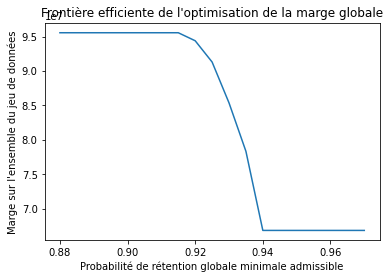

In [ ]:
plt.plot(global_min_retention_rates, total_margins)
plt.title("Efficient frontier of the optimal total profits")
plt.xlabel("Min global retention rate admittible")
plt.ylabel("Total profit over the portfolio")
plt.savefig("### exportation path ###")

It was expected to see that the optimal total profit would reduce when we the min global retention rate imposed as a threshold in the global constraint increases. Indeed, the more we aim to keep a large proportion of clients in our portfolio, the more we have to prescribe fairly low surcharges for them (and even rebates), as most clients see their resiliation probability increase with the surcharge coefficient to prescribe.

The leftward plateau can be explained by the fact that, at a min global retention rate of 0.91, all surcharge coefficients are saturated at 10%, so the total profit cannot be increased anymore. 
The rightward plateau can be explained by the fact that, at a min global retention rate of 0.94, all surcharge coefficients are saturated at -5%, so the total profit cannot be decreased anymore. 

Optimal total profits obtained for the different global min retention rates **using only (a)** (and not the subsequent subproblems):

In [ ]:
[-diffs[i]+total_margins[i] for i in range(len(total_margins))]

[95562464.96649793,
 95562464.96649793,
 95562464.96649793,
 95562464.96649793,
 95562464.96649793,
 95562464.96649793,
 95562464.96649793,
 95562464.96649793,
 92084857.33689259,
 87145071.4571669,
 81676473.0912005,
 74368056.52603617,
 65945210.33016344,
 65945210.33016344,
 65945210.33016344,
 65945210.33016344,
 65945210.33016344,
 65945210.33016344,
 65945210.33016344]

Graph of the gain extracted using the per-cluster subproblems (i.e. **(b)**) right after **(a)**:

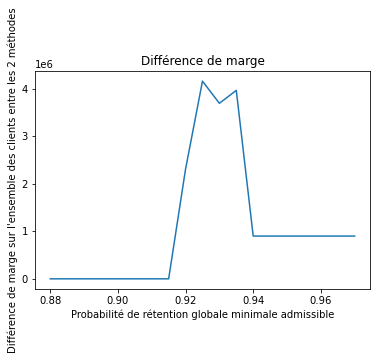

In [ ]:
plt.plot(global_min_retention_rates, diffs)
plt.title("Profit difference between (b) and (a)")
plt.xlabel("Min global retention rate admittible")
plt.ylabel("Profit difference on the whole portfolio between (b) and (a) ((b) builds upon (a))")
plt.savefig("### exportation path ###")

We gain more than 4 million euros by optimizating **(a)** then solving the per-cluster independent subproblems (i.e. **(b)**), in certain cases!